In [24]:
import sys
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import fraud_detection as fd
from fraud_detection import data_loader, metrics

# Add the src directory to the system path to import modules
reload(fd)
sys.path.append('../src')

datapath = "../data/transformed_label_and_damage.parquet"

In [48]:
seed = 43

In [49]:
X, targets = data_loader.load_data_np(datapath)

X_train, X_test, y_train, y_test = map(
  np.asarray, train_test_split(X, targets, test_size=0.2, random_state=seed)
)

In [59]:
def evaluate(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train[:, 0])

  probs_train = model.predict_proba(X_train)[:, 1]
  idx_pos_damage_train = np.where(y_train[:, 1] > 0)[0]

  probs_test = model.predict_proba(X_test)[:, 1]
  preds_test = model.predict(X_test)
  idx_pos_damage_test = np.where(y_test[:, 1] > 0)[0]
  scores = metrics.bewertung(preds_test, y_test[:, 0], y_test[:, 1])

  # two figures: side by side (for test and train data)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle(f"{model.__class__.__name__} - Damage Prediction")
  ax1.set_title("Train Data")
  ax1.set_xlabel("Predicted Probability of Damage")
  ax1.set_ylabel("Actual Damage")
  ax1.scatter(probs_train[idx_pos_damage_train], y_train[:, 1][idx_pos_damage_train], alpha=0.3)
  ax2.set_title("Test Data")
  ax2.set_xlabel("Predicted Probability of Damage")
  ax2.set_ylabel("Actual Damage")
  ax2.scatter(probs_test[idx_pos_damage_test], y_test[:, 1][idx_pos_damage_test], alpha=0.3)
  plt.tight_layout()
  plt.show()
  return scores

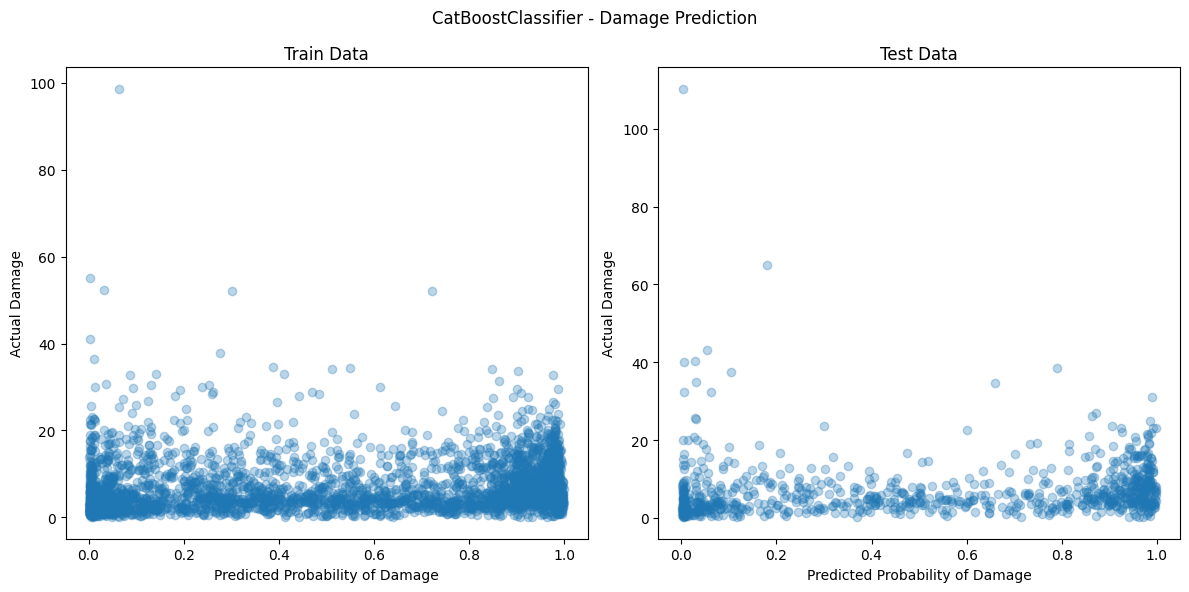

In [61]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_seed=42,
)

scores_cat = evaluate(model, X_train, y_train, X_test, y_test)

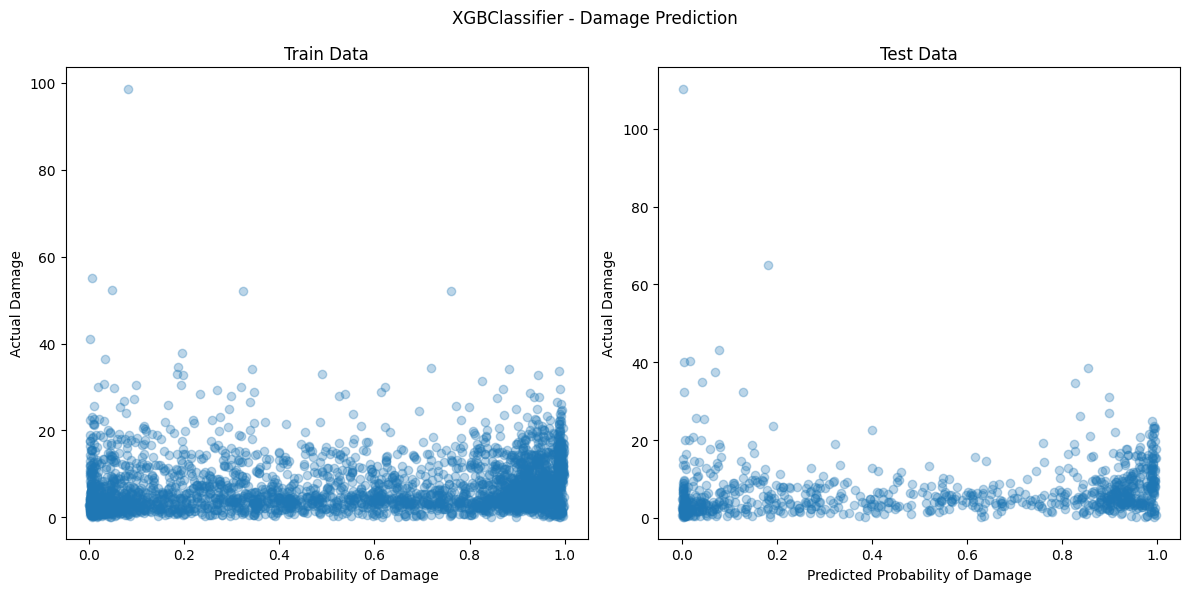

In [60]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
)

scores_xgb = evaluate(model, X_train, y_train, X_test, y_test)

In [56]:
scores_cat

{'cm': array([[28582,    84],
        [  407,   457]]),
 'precision': 0.844731977818854,
 'recall': 0.5289351851851852,
 'f1': 0.6505338078291815,
 'mcc': 0.6610205282119452,
 'damage_total': np.float64(6039.02),
 'damage_prevented': np.float64(3496.24),
 'damage_missed': np.float64(2542.78),
 'detected bonus': np.int64(2285),
 'fp penalty': np.int64(840),
 'Bewertung': np.float64(-1097.78)}

In [57]:
scores_xgb

{'cm': array([[28571,    95],
        [  393,   471]]),
 'precision': 0.8321554770318021,
 'recall': 0.5451388888888888,
 'f1': 0.6587412587412588,
 'mcc': 0.6659810328255806,
 'damage_total': np.float64(6039.02),
 'damage_prevented': np.float64(3543.8500000000004),
 'damage_missed': np.float64(2495.17),
 'detected bonus': np.int64(2355),
 'fp penalty': np.int64(950),
 'Bewertung': np.float64(-1090.1699999999998)}